In [ ]:
!pip install matplotlib --upgrade
!pip install pandas --upgrade
!pip install uncertainties

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import statsmodels.api as sm
from uncertainties import ufloat
from uncertainties.umath import *

plt.style.use('ggplot')

In [2]:
nge_corrente = pd.read_csv('nge_corrente.csv')
nge_campo = pd.read_csv('nge_campo.csv')
pge_corrente = pd.read_csv('pge_corrente.csv')
pge_campo = pd.read_csv('pge_campo.csv')

In [8]:
#Campo constante do n-Ge e p-Ge na varição de corrente (mT)
b_constante = ufloat(300,1)

#Corrente constate do n-Ge e p-Ge na variação de campo (mA)
i_constante = ufloat(25,0.01)

#Espessura da plca de Germanio (mm)
d = 1

#Carga Elementar
e = 1.602E-19

# Efeito Hall

## Definição

É a tensão criada sobre um bateria sob efeito de uma corrente e um campo magnetico ortogonais, esta tensão gerada é ortogonal aos dois.

$V_h \, \rightarrow$ Tensão de Hall

$B \, \rightarrow$ Campo Magnético

$I \, \rightarrow$ Corrente Elétrica

$n \, \rightarrow$ Número de excessos/buracos

$e \, \rightarrow$ Carga Elementar

$d \, \rightarrow$ Espessura do material

\begin{equation*}
  V_h = \frac{B \cdot I}{n\, e\, d}
\end{equation*}

Definindo $R_H = \frac{1}{ne}$:

\begin{equation*}
  V_h = R_h\frac{B \cdot I}{d}
\end{equation*}

Então podemos encontrar $R_h$ com:

\begin{equation*}
  R_h = \frac{d \cdot V_h}{B \cdot I}
\end{equation*}


## Plotando os dados obtidos

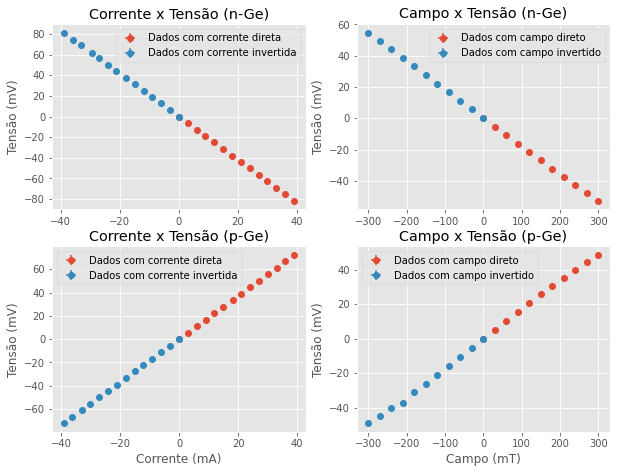

In [4]:
fig1, ax1 = plt.subplots(nrows=2, ncols=2 , figsize=(10,7.5))


#Plot do n-Ge com corrente
xd1 = nge_corrente.iloc[:,0]
yd1 = nge_corrente.iloc[:,1]

xi1 = nge_corrente.iloc[:,2]
yi1 = nge_corrente.iloc[:,3]

ax1[0,0].errorbar(xd1,yd1,xerr=0.01, yerr=0.01, fmt='o', label='Dados com corrente direta')
ax1[0,0].errorbar(xi1,yi1,xerr=0.01, yerr=0.01, fmt='o', label='Dados com corrente invertida')

ax1[0,0].set_title('Corrente x Tensão (n-Ge)')
ax1[0,0].set_ylabel('Tensão (mV)')
ax1[0,0].legend(loc=0)


#Plot do n-Ge com campo
xd2 = nge_campo.iloc[:,0]
yd2 = nge_campo.iloc[:,1]

xi2 = nge_campo.iloc[:,2]
yi2 = nge_campo.iloc[:,3]

ax1[0,1].errorbar(xd2,yd2,xerr=1, yerr=0.01, fmt='o', label='Dados com campo direto')
ax1[0,1].errorbar(xi2,yi2,xerr=1, yerr=0.01, fmt='o', label='Dados com campo invertido')

ax1[0,1].set_title('Campo x Tensão (n-Ge)')
ax1[0,1].set_ylabel('Tensão (mV)')
ax1[0,1].legend(loc=0)



#Plot do p-Ge com corrente
xd3 = pge_corrente.iloc[:,0]
yd3 = pge_corrente.iloc[:,1]

xi3 = pge_corrente.iloc[:,2]
yi3 = pge_corrente.iloc[:,3]

ax1[1,0].errorbar(xd3,yd3,xerr=0.01, yerr=0.01, fmt='o', label='Dados com corrente direta')
ax1[1,0].errorbar(xi3,yi3,xerr=0.01, yerr=0.01, fmt='o', label='Dados com corrente invertida')

ax1[1,0].set_title('Corrente x Tensão (p-Ge)')
ax1[1,0].set_xlabel('Corrente (mA)')
ax1[1,0].set_ylabel('Tensão (mV)')
ax1[1,0].legend(loc=0)



#Plot do p-Ge com campo
xd4 = pge_campo.iloc[:,0]
yd4 = pge_campo.iloc[:,1]

xi4 = pge_campo.iloc[:,2]
yi4 = pge_campo.iloc[:,3]

ax1[1,1].errorbar(xd4,yd4,xerr=1, yerr=0.01, fmt='o', label='Dados com campo direto')
ax1[1,1].errorbar(xi4,yi4,xerr=1, yerr=0.01, fmt='o', label='Dados com campo invertido')

ax1[1,1].set_title('Campo x Tensão (p-Ge)')
ax1[1,1].set_xlabel('Campo (mT)')
ax1[1,1].set_ylabel('Tensão (mV)')
ax1[1,1].legend(loc=0)

## Encontrando a constante $R_h$ e número de excessos/buracos de carga

Para facilitar esta etapa vou criar:

\begin{equation*}
  V_B = \frac{V}{B} \quad , \quad V_I = \frac{V}{I}
\end{equation*}

Para usar depois no calculo da constante $R_h$ com:

\begin{equation*}
  R_h = V_B \cdot \frac{d}{I_{constante}} 
\end{equation*}

\begin{equation*}
  R_h = V_I \cdot \frac{d}{B_{constante}} 
\end{equation*}

In [15]:
#Rh para o n-Ge

#Calculando VI medio da corrente direta e invertida para depois calcular o Rh
nvi_direto = [ufloat(v,0.01)/ufloat(i,0.01) for i,v in zip(nge_corrente.iloc[1:,0],nge_corrente.iloc[1:,1])]
nvi_direto_avg = sum(nvi_direto)/len(nvi_direto)

nvi_invertido = [ufloat(v,0.01)/ufloat(i,0.01) for i,v in zip(nge_corrente.iloc[1:,2],nge_corrente.iloc[1:,3])]
nvi_invertido_avg = sum(nvi_invertido)/len(nvi_invertido)

nrh_vi = ((nvi_direto_avg + nvi_invertido_avg)/2 ) * ( d / b_constante)

#Calculando VI medio do campo direto e invertido para depois calcular o Rh
nvb_direto = [ufloat(v,0.01)/ufloat(b,1) for b,v in zip(nge_campo.iloc[1:,0],nge_campo.iloc[1:,1])]
nvb_direto_avg = sum(nvb_direto)/len(nvb_direto)

nvb_invertido = [ufloat(v,0.01)/ufloat(b,1) for b,v in zip(nge_campo.iloc[1:,2],nge_campo.iloc[1:,3])]
nvb_invertido_avg = sum(nvb_invertido)/len(nvb_invertido)

nrh_vb = ((nvb_direto_avg + nvb_invertido_avg)/2 ) * ( d / i_constante)


#Fazendo o Rh médio

nrh = np.abs((nrh_vi + nrh_vb)/2)

print("Rh = %s" % nrh)

Rh = 0.007120+/-0.000016


In [7]:
#Rh para o p-Ge

#Calculando VI medio da corrente direta e invertida para depois calcular o Rh
pvi_direto = [ufloat(v,0.01)/ufloat(i,0.01) for i,v in zip(pge_corrente.iloc[1:,0],pge_corrente.iloc[1:,1])]
pvi_direto_avg = sum(pvi_direto)/len(pvi_direto)

pvi_invertido = [ufloat(v,0.01)/ufloat(i,0.01) for i,v in zip(pge_corrente.iloc[1:,2],pge_corrente.iloc[1:,3])]
pvi_invertido_avg = sum(pvi_invertido)/len(pvi_invertido)

prh_vi = ((pvi_direto_avg + pvi_invertido_avg)/2 ) * ( d / b_constante)

#Calculando VI medio do campo direto e invertido para depois calcular o Rh
pvb_direto = [ufloat(v,0.01)/ufloat(b,1) for b,v in zip(pge_campo.iloc[1:,0],pge_campo.iloc[1:,1])]
pvb_direto_avg = sum(pvb_direto)/len(pvb_direto)

pvb_invertido = [ufloat(v,0.01)/ufloat(b,1) for b,v in zip(pge_campo.iloc[1:,2],pge_campo.iloc[1:,3])]
pvb_invertido_avg = sum(pvb_invertido)/len(pvb_invertido)

prh_vb = ((pvb_direto_avg + pvb_invertido_avg)/2 ) * ( d / i_constante)


#Fazendo o Rh médio

prh = (prh_vi + prh_vb)/2

print("Rh = %s" % prh)

Rh = 0.006530+/-0.000015


Temos então que o valor de $R_h$ para o n-Ge é dado por:

\begin{equation*}
  R_h = 0,00712 \pm 0,00002 \, m^3/C
\end{equation*}

E para o p-Ge é de:

\begin{equation*}
  R_h = 0,00653 \pm 0,00002 \, m^3/C
\end{equation*}

Com os valores de $R_h$ para n-Ge e p-Ge, podemos encontrar os números de eletrons livres / buracos com a relação desta contante com o número de cargas:

\begin{equation*}
  R_h = \frac{1}{n e} \quad \rightarrow \quad n = \frac{1}{R_h e}
\end{equation*}

Sabendo que $e = 1,602 \cdot 10^{-19}\, C$.

In [16]:
num_n = 1 / (nrh*e)
num_p = 1 / (prh*e)

print(num_n,num_p)

(8.768+/-0.020)e+20 (9.560+/-0.022)e+20


Assim vemos que o número de eletrons livres do n-Ge por $m^3$ é de:

\begin{equation*}
  n_n = (8,77 \pm 0,02)\cdot 10^{20}
\end{equation*}

E o número de de buracos do p-Ge por $m^3$ é dado por:

\begin{equation*}
  n_p = (9,56 \pm 0,02)\cdot 10^{20}
\end{equation*}